In [1]:
# test improvement on transmission dataset
# apply news_filter
# scan for keyword "transmission"

# import necessary items
# mostly copied over from MM_Covid_Explain2.ipynb
# commented some stuff out that I couldn't install
# but that also didn't seem to be needed
import re
# import simdjson as sj
# import gzip
# from tqdm import tqdm
import pandas as pd
# from tqdm.notebook import tqdm
import swifter
# import seaborn as sns
import numpy as np	
# from nltk import sent_tokenize
# from sentence_transformers import SentenceTransformer
# from wutils.general import save_pickle, load_pickle
from wutils.mat import MarkedMatrix
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from treeinterpreter import treeinterpreter as ti
# used to time certain functions that take a long time
# not really needed, but somewhat interesting
import time
# for plotting
import matplotlib.pyplot as plt
# for saving data to a pickle
import pickle

In [2]:
# load cord-19 (reference) data from pickle
# changed from ./pickles/who_cord_df.pkl to ./pickles/newest_cord_df_ft.pkl
# changed from load_pickle to pd.read_pickle
# this gets rid of an error I've been having
start = time.time()
cord_df = pd.read_pickle('./pickles/newest_cord_df_ft.pkl')
end = time.time()
print('seconds: ', end - start)

seconds:  132.41115593910217


In [3]:
# load good (true) data from pickle
# changed from ./pickles/newest_good_sample_df_ft.pkl to clean_good_df.pkl
# also changed from load_pickle to pd.read_pickle
# thanks, stackoverflow!
start = time.time()
good_df = pd.read_pickle('./pickles/clean_good_df.pkl')
end = time.time()
print('seconds: ', end - start)

seconds:  155.05500507354736


In [ ]:
# load bad (false) data from pickle
# changed from ./pickles/newest_bad_df_ft.pkl to cleab_bad_df.pkl
# changed from load_pickle to pd.read_pickle
start = time.time()
bad_df = pd.read_pickle('./pickles/clean_bad_df.pkl')
end = time.time()
print('seconds: ', end - start)

In [ ]:
# example of good article
good_df[good_df.cleanText.swifter.apply(lambda x: 'Virus-ridden particles are inhaled by others and come into contact with cells' in x)]

In [ ]:
# function to parse urls
import urllib.parse

def get_hostname(url):
    o = urllib.parse.urlsplit(url)
    return o.hostname

In [ ]:
# function that returns true if text has to do with keep_if (wuhan in this case)
# returns false if text contains words in blacklist
# if text contains words from neither, defaults to true
def news_filter(text):
    keep_if = ['wuhan']
    text = text.lower()
    blacklist = ['u.s.', 'america', 'korea', 'china', 'mexico', 'australia', 'uk', 'u.k.', 'new york', 'los angeles', 'nfl', 'nba', 'mlb', 'epl']
    if any(x in text for x in keep_if):
        return True
    if any(x in text for x in blacklist):
        return False
    return True

In [ ]:
# not really sure what any of the below does to be honest
# I assume it has to do with preparing the data somehow
good_df['hostname'] = good_df['url'].swifter.apply(get_hostname)
bad_df['hostname'] = bad_df['url'].swifter.apply(get_hostname)

In [ ]:
good_df['mean_embed'] = good_df['sent_embeddings'].swifter.apply(lambda x: x.mean(axis=0))
bad_df['mean_embed'] = bad_df['sent_embeddings'].swifter.apply(lambda x: x.mean(axis=0))

In [ ]:
# seems that we are keeping the bad articles only if they have this "is ap" quality
# I'm not sure what "is ap" means, but that's what this function does
is_AP = bad_df['cleanText'].swifter.apply(lambda x: '(AP)' in x)
print('Found: ', is_AP.sum())
bad_df = bad_df[~is_AP]

In [ ]:
# keyword
KW = 'transmission'

In [12]:
# don't know what this does
# more data prep I guess
cord_df = cord_df.dropna()
cord_df['mean_embed'] = cord_df['sent_embeddings'].swifter.apply(lambda x: x.mean(axis=0))

Pandas Apply:   0%|          | 0/10149 [00:00<?, ?it/s]

In [13]:
# filtering dataframe to look for the keyword
# don't know why will named this "has_vax" if the keyword is transmission
# but I won't question it
has_vax = cord_df[cord_df.title.swifter.apply(lambda x: KW in x.lower()) | cord_df.abstract.swifter.apply(lambda x: KW in x.lower())]
vax_ref = np.vstack(has_vax['mean_embed'])

Pandas Apply:   0%|          | 0/10149 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10149 [00:00<?, ?it/s]

## From the paper:

"We extract only articles that contain the word “transmission” and name it the “transmission news” dataset. The purpose ... is to provide a smaller sample with articles focusing more on attributes of the virus rather than on other topics."

The results for these smaller more specific datasets differs from the overall dataset as well, with the transmission news dataset seeming to fare a little bit worse than the other ones.

To show the effectiveness of his algorithm, Will is choosing to use the *"transmission news"* dataset. 

![table1](../../table_1.png)

In [14]:
# will originally commented this out
# seems to be the old filtering method
# vax_good_df = good_df[good_df['cleanText'].swifter.apply(lambda x: KW in x.lower())]
# vax_bad_df = bad_df[bad_df['cleanText'].swifter.apply(lambda x: KW in x.lower())]

# creating dataframes and cleaning them up
vax_good_df = good_df
vax_bad_df = bad_df

# applying news filter function:
# (removing text containing unwanted keywords, unless they also contain other wanted keywords)
vax_good_df = vax_good_df[vax_good_df['cleanText'].swifter.apply(news_filter)]
vax_bad_df = vax_bad_df[vax_bad_df['cleanText'].swifter.apply(news_filter)]

# turning this into a matrix I think
vax_good_mat = np.vstack(vax_good_df.mean_embed)
vax_bad_mat = np.vstack(vax_bad_df.mean_embed)

# turning matrix into a marked matrix (matrix with labels)
# will's own personal python library actually, impressive
# we don't want to use this vax_raw_mm
# it gives us weird results
# vax_raw_mm = MarkedMatrix([('good', vax_good_mat), ('bad', vax_bad_mat)])

Pandas Apply:   0%|          | 0/97539 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/14867 [00:00<?, ?it/s]

In [15]:
# will calculates the distances between reference dataframe and to-be-labeled dataframe here I am assuming
# below is a link to possible other metrics to use besides cosine
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

# vgood2ref is the distance between vax_good_mat and vax_ref
start = time.time()
vgood2ref = cdist(vax_good_mat, vax_ref, 'cosine')
print('done w/ good')
end = time.time()
print('seconds: ', end-start)

# vbad2ref is the distance between vax_bad_mat and vax_ref
start = time.time()
vbad2ref = cdist(vax_bad_mat, vax_ref, 'cosine')
print('done w/ bad')
end = time.time()
print('seconds: ', end-start)

# turning this into a marked matrix
vax_mm = MarkedMatrix([('good', vgood2ref), ('bad', vbad2ref)])

# theoretically, vgood2ref should contain small distances (since good articles should be similar to CORD-19)
# and vbad2ref should contain large distances (since bad articles should not be similar to CORD-19)

done w/ good
seconds:  10.105858564376831
done w/ bad
seconds:  1.22593092918396


In [16]:
# Alt method
# commented out by Will originally
# has_vax = cord_df.sample(5000)
# vax_ref = np.vstack(has_vax['mean_embed'])

In [17]:
# War on Terror Cells: Strategies to Eradicate "Novel Coronavirus" Effectively
np.where(~np.isfinite(vax_ref))

(array([], dtype=int64), array([], dtype=int64))

In [18]:
# initializing random forest classifiers to be used later
# random forest: a collection of decision trees, where the final decision is the average of all the trees
# the idea is: the crowd is smarter
raw_tmodel = RandomForestClassifier(n_estimators=500, n_jobs=28)
tmodel = RandomForestClassifier(n_estimators=500, n_jobs=28)
tmodel2 = RandomForestClassifier(n_estimators=1500, n_jobs=28)

In [19]:
# finding some examples of good text
tidx = 263
vax_good_df.iloc[tidx].title, vax_good_df.iloc[tidx].cleanText

('Prices of alcohols used in making hand sanitizers capped under Essential Commodities Act',
 'The government on Thursday said prices of alcohols used in manufacturing hand sanitizers have been capped under the Essential Commodities Act on account of coranavirus outbreak.The decision would empower the central government and states/union territories to regulate prices, production, sale, distribution, transport, movement, storage, information of alcohols used in manufacturing hand sanitizers, used as preventive measure to avoid infection from COVID-19 , Ministry of Consumer Affairs said in a statement.It would also empower governments to smoothen the sale and availability of these items and carry out operations against hoarders, speculators, profiteers, black marketeers and those involved in contravention of the orders of central government and states/UTs in respect of these alcohols.It will help manufacturers of hand sanitizers to keep prices of their product at reasonable level and wit

In [20]:
# function written by will to show program's classification decision process for individual documents
def tree_explain_good(idx):
    pred, bias, contrib = ti.predict(tmodel, vgood2ref[idx, :].reshape((1, -1)))
    print('CLEAN TEXT: ', vax_good_df.iloc[idx].cleanText)
    cmat = contrib.reshape((-1, 2))
    print('Prediction: ', pred)
    print('Bias: ', bias)
    import_bad = np.argsort(cmat[:, 0])[::-1]
    import_good = np.argsort(cmat[:, 1])[::-1]
    print('===== Towards Good: =====')
    for idx in import_good[:5]:
        print('-'*45)
        print(f'CONTRIB: {cmat[idx]}')
        print(f'ABSTRACT: {has_vax.iloc[idx].abstract}')
        print(f'TITLE: {has_vax.iloc[idx].title}')
    print('===== Towards Bad: =====')
    for idx in import_bad[:5]:
        print('-'*45)
        print(f'CONTRIB: {cmat[idx]}')
        print(f'ABSTRACT: {has_vax.iloc[idx].abstract}')
        print(f'TITLE: {has_vax.iloc[idx].title}')

# pretty much a copy of the previous function, except used to compare with bad dataset rather than good
def tree_explain_bad(idx):
    pred, bias, contrib = ti.predict(tmodel, vbad2ref[idx, :].reshape((1, -1)))
    print('CLEAN TEXT: ', vax_bad_df.iloc[idx].cleanText)
    cmat = contrib.reshape((-1, 2))
    print('Prediction: ', pred)
    print('Bias: ', bias)
    import_bad = np.argsort(cmat[:, 0])[::-1]
    import_good = np.argsort(cmat[:, 1])[::-1]
    print('===== Towards Bad: =====')
    for idx in import_bad[:5]:
        print('-'*45)
        print(f'CONTRIB: {cmat[idx]}')
        print(f'ABSTRACT: {has_vax.iloc[idx].abstract}')
        print(f'TITLE: {has_vax.iloc[idx].title}')
    print('===== Towards Good: =====')
    for idx in import_good[:5]:
        print('-'*45)
        print(f'CONTRIB: {cmat[idx]}')
        print(f'ABSTRACT: {has_vax.iloc[idx].abstract}')
        print(f'TITLE: {has_vax.iloc[idx].title}')

In [21]:
# this was commented out by will
# vax_mm.mat[~np.isfinite(vax_mm.mat)] = 0

**Training and evaluation begins after this point.**

*Quick Refresher:*
* vax_mm was defined above as a marked matrix of vgood2ref as good, and vbad2ref as bad
* vgood2ref is the matrix of distances between the good matrix and the vax ref
* vbad2ref is the matrix of distances between the bad matrix and the vax ref
* ideally, vgood2ref should have small distances
* while vbad2ref whould have large distances

**Note:** *single_split_classify* is a function from will's wutils python library.

The source can be found here: https://github.com/willshiao/wutils/blob/master/wutils/mat.py

The numbers that single_split_classify returns are in the following format: ((accuracy, f1-score), labels)

**The following trainings and evaluations can be skipped since the data is saved in a text file.**

1. Regular dimensionality
2. k=5
3. k=10
4. k=15
5. k=20
6. k=25
7. k=768

All the data gathered before the first couple of charts can be skipped basically. k=100 is the first training/evaluation sequence that isn't skipped.

In [22]:
# ====== RUN FIRST TIME WITH REGULAR REPRESENTATION OF DATA (REGULAR DIMENSIONALITY) ======
regular = dict()

In [23]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
regular['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9104170395561124, 0.9517194810205952), {'bad': 0, 'good': 1})
seconds:  40.75952386856079


In [24]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
regular['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9110434938249508, 0.9521010023130301), {'bad': 0, 'good': 1})
seconds:  40.686267137527466


In [25]:
# running vax_mm with raw_t_model
# changed this so that we don't use the vax_raw_mm
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
regular['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9114014676928585, 0.9522983521248917), {'bad': 0, 'good': 1})
seconds:  41.48452377319336


In [26]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
regular['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9129228566314659, 0.9531197301854974), {'bad': 0, 'good': 1})
seconds:  119.75182509422302


In [27]:
# running vax_mm with tmodel2
# also changed this so that we don't use vax_raw_mm
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
regular['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9082691963486665, 0.9506475997881458), {'bad': 0, 'good': 1})
seconds:  121.44172286987305


In [30]:
# print the contents of regular
print('Results of training at regular dimensionality')
for e in regular:
    print('===================')
    print(e)
    print('accuracy: ', regular[e][0][0])
    print('f1-score: ', regular[e][0][1])
    print('labels: ', regular[e][1])

Results of training at regular dimensionality
trial_1
accuracy:  0.9104170395561124
f1-score:  0.9517194810205952
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9110434938249508
f1-score:  0.9521010023130301
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9114014676928585
f1-score:  0.9522983521248917
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9129228566314659
f1-score:  0.9531197301854974
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9082691963486665
f1-score:  0.9506475997881458
labels:  {'bad': 0, 'good': 1}


**Testing out low-dimensional representations of data:**

>"Currently, both articles and references “live” in a multidimensional BERT space and we are computing distances/similarities in that space.
Many times, it is a beneficial to first compute a low-dimensional representation of the data and then do the same sort of distance computation, but in the reduced space." -Vagelis

*Here are the steps that will be taken:*

1. As of right now, there are separate matrices for the reference document BERT and article BERT.
2. These BERT matrices are to be vertically concatenated into a new matrix M.
3. We will run a matrix decomposition on M to receive M=US*V.
4. We grab k (with k being various constants) columns of matrix U to form Uk.
5. We un-concatenate U to reconstitute a smaller version of the article BERT and reference document BERT matrices.
6. We feed these two new matrices into the remainder of Will’s algorithm.
7. Compare the results with the base case (regular representation of the data).

*Set of k to test on:* k = [5, 10, 15, 20, 25, 30, 35]

In [29]:
# step 1: vertically concatenate vax_good_mat and vax_ref
# need to make sure to keep track of how many rows vax_good_mat and vax_ref are
vax_good_mat_shape = vax_good_mat.shape
vax_ref_shape = vax_ref.shape

M = np.vstack((vax_good_mat, vax_ref))

# print the shapes
print(vax_good_mat_shape)
print(vax_ref_shape)

(39926, 768)
(694, 768)


In [31]:
# step 2: run a matrix decomposition on M
# function documentation found here:
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
start = time.time()
U, S, Vh = np.linalg.svd(M, full_matrices=True)
end = time.time()
print('seconds: ', end-start)

# print(U)
print(U.shape)

seconds:  299.22745847702026
(40620, 40620)


In [32]:
# step 3: grab k columns to form Uk
# start out by using k = 5
k = 5
Uk = np.delete(U, np.s_[k:], axis=1)

print(Uk.shape)

(40620, 5)


In [33]:
# step 4: reconstitute vax_good_mat and vax_ref
# remember: vax_good_mat is on top of vax_ref
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)

# should be big
print(new_vax_good_mat.shape)
# should be small
print(new_vax_ref.shape)

(39926, 5)
(694, 5)


In [34]:
# step 5: feed this back into the distance function:
# vgood2ref is the distance between vax_good_mat and vax_ref
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')

print('done w/ good')

done w/ good


In [35]:
# now we repeat the same steps for bad mat:
# step 1: vertically concatenate vax_bad_mat and vax_ref
vax_bad_mat_shape = vax_bad_mat.shape
# we already have vax_ref_shape so we can skip this
# vax_ref_shape = vax_ref.shape
M = np.vstack((vax_bad_mat, vax_ref))

print(vax_bad_mat_shape)
print(vax_ref_shape)

(4768, 768)
(694, 768)


In [36]:
# step 2: run a matrix decomposition on M
start = time.time()
U, S, Vh = np.linalg.svd(M, full_matrices=True)
end = time.time()
print(end-start)

# print(U)
print(U.shape)

6.195513010025024
(5462, 5462)


In [37]:
# step 3: grab k columns to form Uk
# start out by using k = 5
# once again, already have this
# k = 5
Uk = np.delete(U, np.s_[k:], axis=1)

print(Uk.shape)

(5462, 5)


In [38]:
# step 4: reconstitute vax_good_mat and vax_ref
# remember: vax_good_mat is on top of vax_ref
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)

print(new_vax_bad_mat.shape)
print(new_vax_ref.shape)

(4768, 5)
(694, 5)


In [39]:
# step 5: feed this back into the distance function:
# vgood2ref is the distance between vax_good_mat and vax_ref
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
print('done w/ bad')

done w/ bad


In [40]:
# create our markedMatrix
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

In [41]:
# ====== RUN WITH k=5 ======
k5 = dict()

In [42]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k5['trial_1'] = res
end = time.time()
print('seconds: ', end-start)

trial_1:
Training model...
Evaluating model...
((1.0, 1.0), {'bad': 0, 'good': 1})
seconds:  35.929675817489624


In [43]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k5['trial_2'] = res
end = time.time()
print('seconds: ', end-start)

trial_2:
Training model...
Evaluating model...
((0.999910506533023, 0.9999502116006971), {'bad': 0, 'good': 1})
seconds:  35.23275566101074


In [44]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k5['trial_3'] = res
end = time.time()
print('seconds: ', end-start)

trial_3:
Training model...
Evaluating model...
((1.0, 1.0), {'bad': 0, 'good': 1})
seconds:  36.75368404388428


In [45]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k5['trial_4'] = res
end = time.time()
print('seconds: ', end-start)

trial_4:
Training model...
Evaluating model...
((0.999910506533023, 0.9999498269028146), {'bad': 0, 'good': 1})
seconds:  107.93765115737915


In [46]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k5['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((1.0, 1.0), {'bad': 0, 'good': 1})
seconds:  105.0549533367157


In [47]:
# print the contents of k5
print('Results of training with k=5')
for e in k5:
    print('===================')
    print(e)
    print('accuracy: ', k5[e][0][0])
    print('f1-score: ', k5[e][0][1])
    print('labels: ', k5[e][1])

Results of training with k=5
trial_1
accuracy:  1.0
f1-score:  1.0
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.999910506533023
f1-score:  0.9999502116006971
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  1.0
f1-score:  1.0
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.999910506533023
f1-score:  0.9999498269028146
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  1.0
f1-score:  1.0
labels:  {'bad': 0, 'good': 1}


In [48]:
# now we try this again with k=10

# already have the shapes so we don't need this
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 10

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  301.2636818885803
done w/ bad
seconds:  6.350571393966675


In [49]:
# ====== RUN WITH k=10 ======
k10 = dict()

In [50]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k10['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9939144442455701, 0.9966027178257395), {'bad': 0, 'good': 1})
seconds:  104.57657361030579


In [51]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k10['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9943619115804546, 0.9968444778362134), {'bad': 0, 'good': 1})
seconds:  104.29360628128052


In [52]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k10['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9948093789153392, 0.9971054995508534), {'bad': 0, 'good': 1})
seconds:  100.23731064796448


In [53]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k10['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9953463397172007, 0.997407518197228), {'bad': 0, 'good': 1})
seconds:  299.0952568054199


In [54]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k10['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9962412743869697, 0.9979018883005295), {'bad': 0, 'good': 1})
seconds:  301.1634290218353


In [55]:
# print the contents of k10
print('Results of training with k=10')
for e in k10:
    print('===================')
    print(e)
    print('accuracy: ', k10[e][0][0])
    print('f1-score: ', k10[e][0][1])
    print('labels: ', k10[e][1])

Results of training with k=10
trial_1
accuracy:  0.9939144442455701
f1-score:  0.9966027178257395
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9943619115804546
f1-score:  0.9968444778362134
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9948093789153392
f1-score:  0.9971054995508534
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9953463397172007
f1-score:  0.997407518197228
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9962412743869697
f1-score:  0.9979018883005295
labels:  {'bad': 0, 'good': 1}


In [56]:
# now we try this again with k=15

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 15

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  299.5103178024292
done w/ bad
seconds:  6.465120077133179


In [57]:
# ====== RUN WITH k=15 ======
k15 = dict()

In [58]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k15['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.982996241274387, 0.9905912647320987), {'bad': 0, 'good': 1})
seconds:  83.56665468215942


In [59]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k15['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9823697870055486, 0.9902470419327689), {'bad': 0, 'good': 1})
seconds:  85.89862537384033


In [60]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k15['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9823697870055486, 0.9902788058228473), {'bad': 0, 'good': 1})
seconds:  84.46584272384644


In [61]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k15['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9810273850008949, 0.9894914246059284), {'bad': 0, 'good': 1})
seconds:  249.5921368598938


In [62]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k15['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9838016824771791, 0.9910453668431207), {'bad': 0, 'good': 1})
seconds:  247.42367339134216


In [63]:
# print the contents of k15
print('Results of training with k=15')
for e in k15:
    print('===================')
    print(e)
    print('accuracy: ', k15[e][0][0])
    print('f1-score: ', k15[e][0][1])
    print('labels: ', k15[e][1])

Results of training with k=15
trial_1
accuracy:  0.982996241274387
f1-score:  0.9905912647320987
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9823697870055486
f1-score:  0.9902470419327689
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9823697870055486
f1-score:  0.9902788058228473
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9810273850008949
f1-score:  0.9894914246059284
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9838016824771791
f1-score:  0.9910453668431207
labels:  {'bad': 0, 'good': 1}


In [64]:
# now we try this again with k=20

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 20

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  303.5797379016876
done w/ bad
seconds:  6.11121392250061


In [65]:
# ====== RUN WITH k=20 ======
k20 = dict()

In [66]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k20['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9676928584213352, 0.9822647998034881), {'bad': 0, 'good': 1})
seconds:  69.11628985404968


In [67]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k20['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9625917308036513, 0.979410895478278), {'bad': 0, 'good': 1})
seconds:  71.38185143470764


In [68]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k20['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9616967961338823, 0.9789121009065825), {'bad': 0, 'good': 1})
seconds:  71.39282965660095


In [69]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k20['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9633971720064435, 0.9798690751587341), {'bad': 0, 'good': 1})
seconds:  208.83647513389587


In [70]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k20['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.961965276534813, 0.9790609449672365), {'bad': 0, 'good': 1})
seconds:  209.13214588165283


In [71]:
# print the contents of k20
print('Results of training with k=20')
for e in k20:
    print('===================')
    print(e)
    print('accuracy: ', k20[e][0][0])
    print('f1-score: ', k20[e][0][1])
    print('labels: ', k20[e][1])

Results of training with k=20
trial_1
accuracy:  0.9676928584213352
f1-score:  0.9822647998034881
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9625917308036513
f1-score:  0.979410895478278
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9616967961338823
f1-score:  0.9789121009065825
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9633971720064435
f1-score:  0.9798690751587341
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.961965276534813
f1-score:  0.9790609449672365
labels:  {'bad': 0, 'good': 1}


In [72]:
# now we try this again with k=25

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 25

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  303.0942440032959
done w/ bad
seconds:  5.782266139984131


In [73]:
# ====== RUN WITH k=25 ======
k25 = dict()

In [74]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k25['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9520315017003759, 0.9738434511028694), {'bad': 0, 'good': 1})
seconds:  68.03275513648987


In [75]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k25['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9495256846250224, 0.9724501758499414), {'bad': 0, 'good': 1})
seconds:  67.03186559677124


In [76]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k25['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9544478253087525, 0.9751185413305958), {'bad': 0, 'good': 1})
seconds:  65.8943738937378


In [77]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k25['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9515840343654913, 0.9735516988511367), {'bad': 0, 'good': 1})
seconds:  197.79481863975525


In [78]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k25['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.9546268122427063, 0.975377592151911), {'bad': 0, 'good': 1})
seconds:  198.4162895679474


In [79]:
# print the contents of k25
print('Results of training with k=25')
for e in k25:
    print('===================')
    print(e)
    print('accuracy: ', k25[e][0][0])
    print('f1-score: ', k25[e][0][1])
    print('labels: ', k25[e][1])

Results of training with k=25
trial_1
accuracy:  0.9520315017003759
f1-score:  0.9738434511028694
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9495256846250224
f1-score:  0.9724501758499414
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9544478253087525
f1-score:  0.9751185413305958
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9515840343654913
f1-score:  0.9735516988511367
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.9546268122427063
f1-score:  0.975377592151911
labels:  {'bad': 0, 'good': 1}


In [80]:
# ====== RUN WITH k=768 ======
k768 = dict()

In [81]:
# now we try this again with k=768

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 768

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  314.8466053009033
done w/ bad
seconds:  7.53996467590332


In [82]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k768['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.8992303561839986, 0.9466906542941009), {'bad': 0, 'good': 1})
seconds:  47.24573063850403


In [83]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k768['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.8939502416323608, 0.9437134850140123), {'bad': 0, 'good': 1})
seconds:  47.09031128883362


In [84]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k768['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.8992303561839986, 0.946710837671557), {'bad': 0, 'good': 1})
seconds:  47.74734616279602


In [85]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k768['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.8951136567030606, 0.944344192230981), {'bad': 0, 'good': 1})
seconds:  139.72723841667175


In [86]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k768['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.8983354215142295, 0.9461713419257013), {'bad': 0, 'good': 1})
seconds:  137.92243432998657


In [87]:
# print the contents of k768
print('Results of training with k=768')
for e in k768:
    print('===================')
    print(e)
    print('accuracy: ', k768[e][0][0])
    print('f1-score: ', k768[e][0][1])
    print('labels: ', k768[e][1])

Results of training with k=768
trial_1
accuracy:  0.8992303561839986
f1-score:  0.9466906542941009
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.8939502416323608
f1-score:  0.9437134850140123
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.8992303561839986
f1-score:  0.946710837671557
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.8951136567030606
f1-score:  0.944344192230981
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.8983354215142295
f1-score:  0.9461713419257013
labels:  {'bad': 0, 'good': 1}


In [88]:
# prepping variables for plotting
kVals = [5, 10, 15, 20, 25]

trials = ['trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5']
kData = [k5, k10, k15, k20, k25]

acc_results = dict()
acc_results['trial_1'] = []
acc_results['trial_2'] = []
acc_results['trial_3'] = []
acc_results['trial_4'] = []
acc_results['trial_5'] = []

for e in trials:
    for f in kData:
        acc_results[e].append(f[e][0][0])

In [89]:
print(acc_results)

{'trial_1': [1.0, 0.9939144442455701, 0.982996241274387, 0.9676928584213352, 0.9520315017003759], 'trial_2': [0.999910506533023, 0.9943619115804546, 0.9823697870055486, 0.9625917308036513, 0.9495256846250224], 'trial_3': [1.0, 0.9948093789153392, 0.9823697870055486, 0.9616967961338823, 0.9544478253087525], 'trial_4': [0.999910506533023, 0.9953463397172007, 0.9810273850008949, 0.9633971720064435, 0.9515840343654913], 'trial_5': [1.0, 0.9962412743869697, 0.9838016824771791, 0.961965276534813, 0.9546268122427063]}


In [90]:
# more data prep
f1_results = dict()
f1_results['trial_1'] = []
f1_results['trial_2'] = []
f1_results['trial_3'] = []
f1_results['trial_4'] = []
f1_results['trial_5'] = []

for e in trials:
    for f in kData:
        f1_results[e].append(f[e][0][1])

In [91]:
print(f1_results)

{'trial_1': [1.0, 0.9966027178257395, 0.9905912647320987, 0.9822647998034881, 0.9738434511028694], 'trial_2': [0.9999502116006971, 0.9968444778362134, 0.9902470419327689, 0.979410895478278, 0.9724501758499414], 'trial_3': [1.0, 0.9971054995508534, 0.9902788058228473, 0.9789121009065825, 0.9751185413305958], 'trial_4': [0.9999498269028146, 0.997407518197228, 0.9894914246059284, 0.9798690751587341, 0.9735516988511367], 'trial_5': [1.0, 0.9979018883005295, 0.9910453668431207, 0.9790609449672365, 0.975377592151911]}


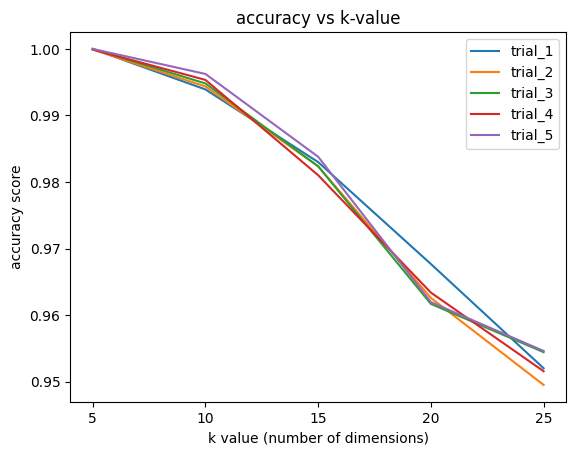

In [92]:
# plot accuracy vs k-value
for e in acc_results:
    plt.plot(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.xticks(kVals)
plt.title('accuracy vs k-value')
plt.show()

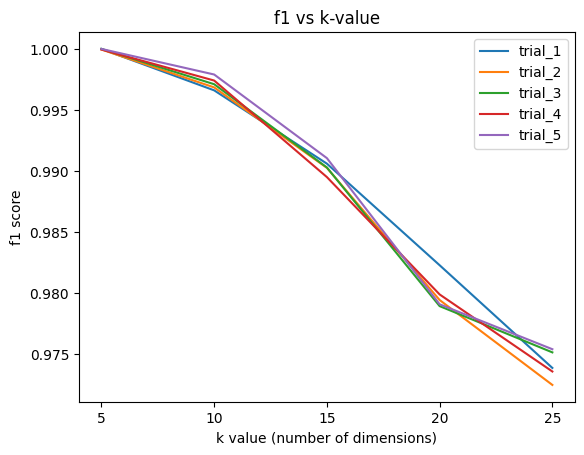

In [93]:
# plot f1 vs k_value
for e in acc_results:
    plt.plot(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.xticks(kVals)
plt.title('f1 vs k-value')
plt.show()

In [94]:
# include k768 this time
kVals.append(768)
for e in trials:
    acc_results[e].append(k768[e][0][0])
    f1_results[e].append(k768[e][0][1])

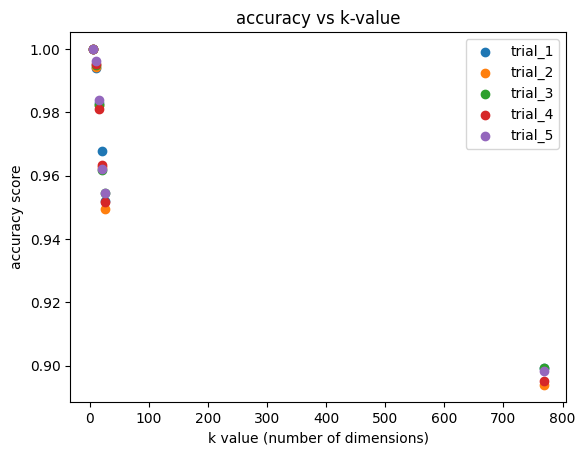

In [95]:
# plot accuracy vs k-value
for e in acc_results:
    plt.scatter(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.title('accuracy vs k-value')
plt.show()

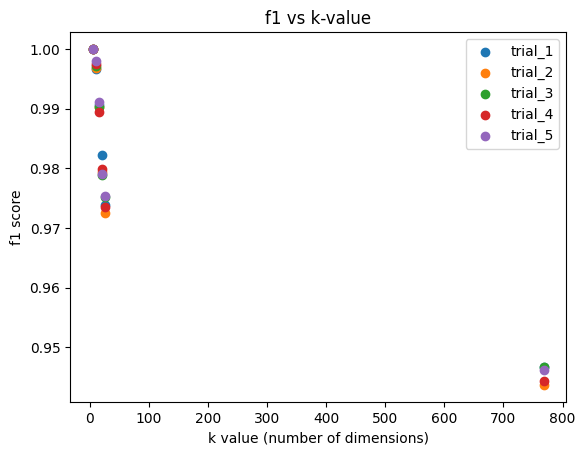

In [96]:
# plot f1 vs k_value
for e in acc_results:
    plt.scatter(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.title('f1 vs k-value')
plt.show()

**The data is being saved to a pickle in the next two boxes.**

Feel free to skip this if you are re-running preivous trials unless you want to overwrite the pkl file.

In [98]:
# saving kData to pickle
# kData is the collection of all the previous trials
file = open('./pickles/training_results_transmission_1.pkl', 'wb')
kData.append(k768)
kData.append(regular)
print(kData)
pickle.dump(kData, file)
file.close()

[{'trial_1': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_2': ((0.999910506533023, 0.9999502116006971), {'bad': 0, 'good': 1}), 'trial_3': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_4': ((0.999910506533023, 0.9999498269028146), {'bad': 0, 'good': 1}), 'trial_5': ((1.0, 1.0), {'bad': 0, 'good': 1})}, {'trial_1': ((0.9939144442455701, 0.9966027178257395), {'bad': 0, 'good': 1}), 'trial_2': ((0.9943619115804546, 0.9968444778362134), {'bad': 0, 'good': 1}), 'trial_3': ((0.9948093789153392, 0.9971054995508534), {'bad': 0, 'good': 1}), 'trial_4': ((0.9953463397172007, 0.997407518197228), {'bad': 0, 'good': 1}), 'trial_5': ((0.9962412743869697, 0.9979018883005295), {'bad': 0, 'good': 1})}, {'trial_1': ((0.982996241274387, 0.9905912647320987), {'bad': 0, 'good': 1}), 'trial_2': ((0.9823697870055486, 0.9902470419327689), {'bad': 0, 'good': 1}), 'trial_3': ((0.9823697870055486, 0.9902788058228473), {'bad': 0, 'good': 1}), 'trial_4': ((0.9810273850008949, 0.9894914246059284), {'bad': 0, 'good': 1

In [99]:
print(kData)

[{'trial_1': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_2': ((0.999910506533023, 0.9999502116006971), {'bad': 0, 'good': 1}), 'trial_3': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_4': ((0.999910506533023, 0.9999498269028146), {'bad': 0, 'good': 1}), 'trial_5': ((1.0, 1.0), {'bad': 0, 'good': 1})}, {'trial_1': ((0.9939144442455701, 0.9966027178257395), {'bad': 0, 'good': 1}), 'trial_2': ((0.9943619115804546, 0.9968444778362134), {'bad': 0, 'good': 1}), 'trial_3': ((0.9948093789153392, 0.9971054995508534), {'bad': 0, 'good': 1}), 'trial_4': ((0.9953463397172007, 0.997407518197228), {'bad': 0, 'good': 1}), 'trial_5': ((0.9962412743869697, 0.9979018883005295), {'bad': 0, 'good': 1})}, {'trial_1': ((0.982996241274387, 0.9905912647320987), {'bad': 0, 'good': 1}), 'trial_2': ((0.9823697870055486, 0.9902470419327689), {'bad': 0, 'good': 1}), 'trial_3': ((0.9823697870055486, 0.9902788058228473), {'bad': 0, 'good': 1}), 'trial_4': ((0.9810273850008949, 0.9894914246059284), {'bad': 0, 'good': 1

**Data from previous testing is being loaded in the next 2 cells.**

Start here if you do not wish to run all the previous trials again and simply start with k=100. 

*However, you can skip this if you ran up to this point from the beginning.*

In [22]:
# loading kData from pickle
file = open('./pickles/training_results_transmission_1.pkl', 'rb')
kData = pickle.load(file)
file.close()

<function BufferedReader.close>

In [24]:
# re-prepping variables after loading them from 
kVals = [5, 10, 15, 20, 25]

trials = ['trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5']
# removing regular from kData
regular = kData.pop()
# removing k768 from kData
# this will be added back later
k768 = kData.pop()
print(kData)

acc_results = dict()
acc_results['trial_1'] = []
acc_results['trial_2'] = []
acc_results['trial_3'] = []
acc_results['trial_4'] = []
acc_results['trial_5'] = []

f1_results = dict()
f1_results['trial_1'] = []
f1_results['trial_2'] = []
f1_results['trial_3'] = []
f1_results['trial_4'] = []
f1_results['trial_5'] = []

for e in trials:
    for f in kData:
        acc_results[e].append(f[e][0][0])
        f1_results[e].append(f[e][0][1])

[{'trial_1': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_2': ((0.999910506533023, 0.9999502116006971), {'bad': 0, 'good': 1}), 'trial_3': ((1.0, 1.0), {'bad': 0, 'good': 1}), 'trial_4': ((0.999910506533023, 0.9999498269028146), {'bad': 0, 'good': 1}), 'trial_5': ((1.0, 1.0), {'bad': 0, 'good': 1})}, {'trial_1': ((0.9939144442455701, 0.9966027178257395), {'bad': 0, 'good': 1}), 'trial_2': ((0.9943619115804546, 0.9968444778362134), {'bad': 0, 'good': 1}), 'trial_3': ((0.9948093789153392, 0.9971054995508534), {'bad': 0, 'good': 1}), 'trial_4': ((0.9953463397172007, 0.997407518197228), {'bad': 0, 'good': 1}), 'trial_5': ((0.9962412743869697, 0.9979018883005295), {'bad': 0, 'good': 1})}, {'trial_1': ((0.982996241274387, 0.9905912647320987), {'bad': 0, 'good': 1}), 'trial_2': ((0.9823697870055486, 0.9902470419327689), {'bad': 0, 'good': 1}), 'trial_3': ((0.9823697870055486, 0.9902788058228473), {'bad': 0, 'good': 1}), 'trial_4': ((0.9810273850008949, 0.9894914246059284), {'bad': 0, 'good': 1

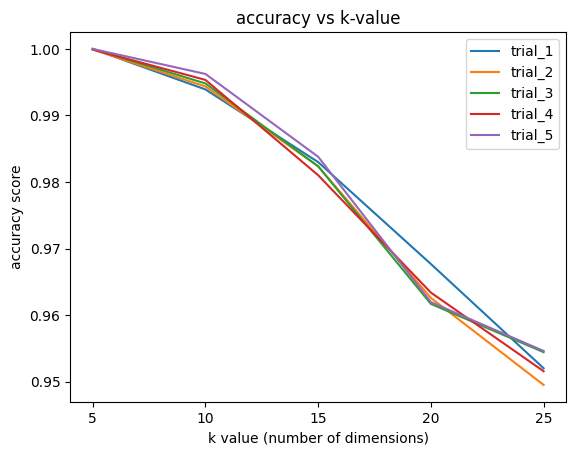

In [26]:
# print graphs again to make sure the data is working
# plot accuracy vs k-value
for e in acc_results:
    plt.plot(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.xticks(kVals)
plt.title('accuracy vs k-value')
plt.show()

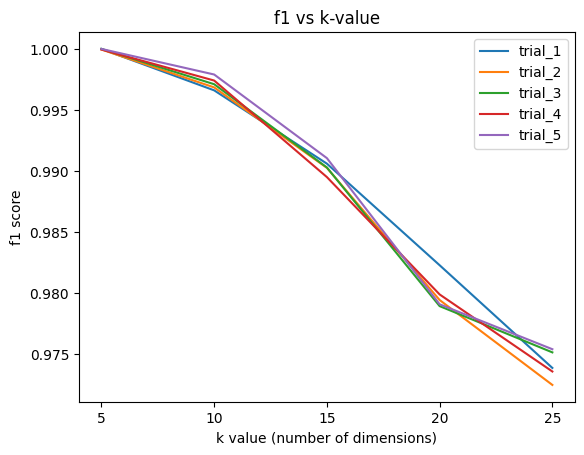

In [27]:
# plot f1 vs k_value
for e in acc_results:
    plt.plot(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.xticks(kVals)
plt.title('f1 vs k-value')
plt.show()

In [28]:
# do additional testing with k = 100, 200, 300, and 500

# no longer have this so we need it again
vax_good_mat_shape = vax_good_mat.shape
vax_ref_shape = vax_ref.shape

k = 100

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  238.92639207839966
done w/ bad
seconds:  6.172993183135986


In [29]:
# ========= RUN WITH k=100 ==========
k100 = dict()

In [30]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k100['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9022731340612136, 0.9483394833948339), {'bad': 0, 'good': 1})
seconds:  54.00516724586487


In [31]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k100['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.8975299803114373, 0.9456702253855279), {'bad': 0, 'good': 1})
seconds:  54.56436729431152


In [32]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k100['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.897798460712368, 0.945866514979143), {'bad': 0, 'good': 1})
seconds:  55.20480799674988


In [33]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k100['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9019151601933059, 0.9481796690307328), {'bad': 0, 'good': 1})
seconds:  159.92372584342957


In [34]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k100['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.8972614999105065, 0.9455304611880813), {'bad': 0, 'good': 1})
seconds:  159.75615286827087


In [35]:
# print the contents of k100
print('Results of training with k=100')
for e in k100:
    print('===================')
    print(e)
    print('accuracy: ', k100[e][0][0])
    print('f1-score: ', k100[e][0][1])
    print('labels: ', k100[e][1])

Results of training with k=100
trial_1
accuracy:  0.9022731340612136
f1-score:  0.9483394833948339
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.8975299803114373
f1-score:  0.9456702253855279
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.897798460712368
f1-score:  0.945866514979143
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9019151601933059
f1-score:  0.9481796690307328
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.8972614999105065
f1-score:  0.9455304611880813
labels:  {'bad': 0, 'good': 1}


In [36]:
# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 200

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  232.6042091846466
done w/ bad
seconds:  6.200544118881226


In [37]:
# ========= RUN WITH k200 ==========
k200 = dict()

In [38]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k200['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.8990513692500447, 0.9466212379329927), {'bad': 0, 'good': 1})
seconds:  55.55285882949829


In [39]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k200['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9017361732593521, 0.9480162863365211), {'bad': 0, 'good': 1})
seconds:  55.235774755477905


In [40]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k200['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.892786826561661, 0.9430662484554699), {'bad': 0, 'good': 1})
seconds:  55.72273254394531


In [41]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k200['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.8999463039198139, 0.9470694063062209), {'bad': 0, 'good': 1})
seconds:  164.17081952095032


In [42]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k200['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.8974404868444603, 0.9456356736242885), {'bad': 0, 'good': 1})
seconds:  161.89628076553345


In [43]:
# print the contents of k200
print('Results of training with k=200')
for e in k200:
    print('===================')
    print(e)
    print('accuracy: ', k200[e][0][0])
    print('f1-score: ', k200[e][0][1])
    print('labels: ', k200[e][1])

Results of training with k=200
trial_1
accuracy:  0.8990513692500447
f1-score:  0.9466212379329927
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9017361732593521
f1-score:  0.9480162863365211
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.892786826561661
f1-score:  0.9430662484554699
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.8999463039198139
f1-score:  0.9470694063062209
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.8974404868444603
f1-score:  0.9456356736242885
labels:  {'bad': 0, 'good': 1}


In [44]:
# do additional testing with k = 100, 200, 300, and 500

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 300

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  249.00461554527283
done w/ bad
seconds:  6.7855188846588135


In [45]:
# ========= RUN WITH k=300 ==========
k300 = dict()

In [46]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k300['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9006622516556292, 0.9474929044465468), {'bad': 0, 'good': 1})
seconds:  54.55919551849365


In [47]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k300['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.8974404868444603, 0.9457077885162024), {'bad': 0, 'good': 1})
seconds:  54.91576266288757


In [48]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k300['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.8969930195095758, 0.945442479973456), {'bad': 0, 'good': 1})
seconds:  54.575849533081055


In [49]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k300['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.8969930195095758, 0.9454269593665544), {'bad': 0, 'good': 1})
seconds:  158.16681289672852


In [50]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k300['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.8976194737784142, 0.9457202505219208), {'bad': 0, 'good': 1})
seconds:  159.40552687644958


In [51]:
# print the contents of k300
print('Results of training with k=300')
for e in k300:
    print('===================')
    print(e)
    print('accuracy: ', k300[e][0][0])
    print('f1-score: ', k300[e][0][1])
    print('labels: ', k300[e][1])

Results of training with k=300
trial_1
accuracy:  0.9006622516556292
f1-score:  0.9474929044465468
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.8974404868444603
f1-score:  0.9457077885162024
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.8969930195095758
f1-score:  0.945442479973456
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.8969930195095758
f1-score:  0.9454269593665544
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.8976194737784142
f1-score:  0.9457202505219208
labels:  {'bad': 0, 'good': 1}


In [52]:
# do additional testing with k = 100, 200, 300, and 500

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 500

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  230.65980052947998
done w/ bad
seconds:  7.8960747718811035


In [53]:
# ========= RUN WITH k=500 ==========
k500 = dict()

In [54]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k500['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.8941292285663146, 0.94382449309084), {'bad': 0, 'good': 1})
seconds:  51.022382736206055


In [55]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k500['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.8991408627170216, 0.9466256215960218), {'bad': 0, 'good': 1})
seconds:  50.9838445186615


In [56]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k500['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.8977089672453911, 0.9458422174840085), {'bad': 0, 'good': 1})
seconds:  50.699804067611694


In [57]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k500['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.9004832647216753, 0.9473634384171163), {'bad': 0, 'good': 1})
seconds:  147.5189905166626


In [58]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k500['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.8981564345802756, 0.946097006441834), {'bad': 0, 'good': 1})
seconds:  148.65939855575562


In [59]:
# print the contents of k500
print('Results of training with k=500')
for e in k500:
    print('===================')
    print(e)
    print('accuracy: ', k500[e][0][0])
    print('f1-score: ', k500[e][0][1])
    print('labels: ', k500[e][1])

Results of training with k=500
trial_1
accuracy:  0.8941292285663146
f1-score:  0.94382449309084
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.8991408627170216
f1-score:  0.9466256215960218
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.8977089672453911
f1-score:  0.9458422174840085
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.9004832647216753
f1-score:  0.9473634384171163
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.8981564345802756
f1-score:  0.946097006441834
labels:  {'bad': 0, 'good': 1}


In [61]:
# plotting again with more values this time

kVals = [5, 10, 15, 20, 25, 100, 200, 300, 500, 768]

trials = ['trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5']
# kData = [k5, k10, k15, k20, k25]
kData.extend([k100, k200, k300, k500, k768])
# kData = [k5, k10, k15, k20, k25, k100, k200, k300, k500, k768]

acc_results = dict()
acc_results['trial_1'] = []
acc_results['trial_2'] = []
acc_results['trial_3'] = []
acc_results['trial_4'] = []
acc_results['trial_5'] = []

for e in trials:
    for f in kData:
        acc_results[e].append(f[e][0][0])

# more data prep
f1_results = dict()
f1_results['trial_1'] = []
f1_results['trial_2'] = []
f1_results['trial_3'] = []
f1_results['trial_4'] = []
f1_results['trial_5'] = []

for e in trials:
    for f in kData:
        f1_results[e].append(f[e][0][1])

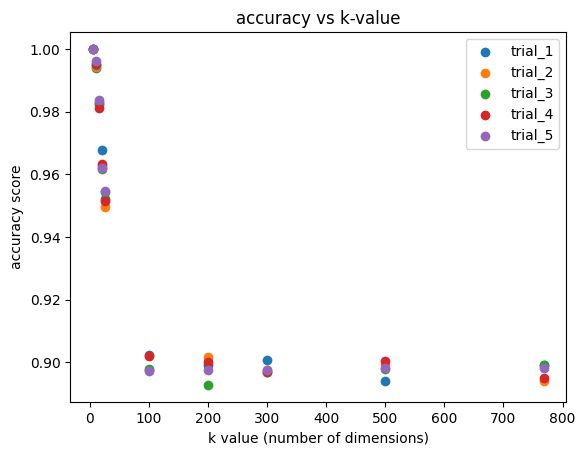

In [63]:
# plot accuracy vs k-value
for e in acc_results:
    plt.scatter(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.title('accuracy vs k-value')
plt.show()

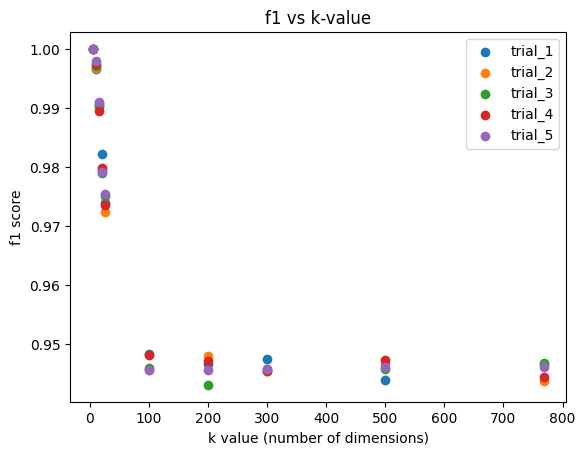

In [64]:
# plot f1 vs k_value
for e in acc_results:
    plt.scatter(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.title('f1 vs k-value')
plt.show()

In [65]:
# going to try with 50 and 75 for a better looking graph

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 50

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  249.92830228805542
done w/ bad
seconds:  6.100217342376709


In [66]:
# ========= RUN WITH k=50 ==========
k50 = dict()

In [67]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k50['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9012887059244675, 0.947717684978907), {'bad': 0, 'good': 1})
seconds:  53.76700949668884


In [68]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k50['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.9023626275281904, 0.9482374151919153), {'bad': 0, 'good': 1})
seconds:  52.72409009933472


In [69]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k50['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.9034365491319134, 0.948898887047123), {'bad': 0, 'good': 1})
seconds:  53.99274969100952


In [70]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k50['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.8956506175049221, 0.9444867644258237), {'bad': 0, 'good': 1})
seconds:  160.19483304023743


In [71]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k50['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.8996778235188831, 0.9467736574711553), {'bad': 0, 'good': 1})
seconds:  159.18705368041992


In [72]:
# print the contents of k50
print('Results of training with k=50')
for e in k50:
    print('===================')
    print(e)
    print('accuracy: ', k50[e][0][0])
    print('f1-score: ', k50[e][0][1])
    print('labels: ', k50[e][1])

Results of training with k=50
trial_1
accuracy:  0.9012887059244675
f1-score:  0.947717684978907
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.9023626275281904
f1-score:  0.9482374151919153
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.9034365491319134
f1-score:  0.948898887047123
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.8956506175049221
f1-score:  0.9444867644258237
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.8996778235188831
f1-score:  0.9467736574711553
labels:  {'bad': 0, 'good': 1}


In [73]:
# going to try with 50 and 75 for a better looking graph
# do additional testing with k = 100, 200, 300, and 500

# already have this below
# vax_good_mat_shape = vax_good_mat.shape
# vax_ref_shape = vax_ref.shape

k = 75

# good
start = time.time()
M = np.vstack((vax_good_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_good_mat = np.delete(Uk, np.s_[vax_good_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_good_mat_shape[0]], axis=0)
newvgood2ref = cdist(new_vax_good_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ good')
print('seconds: ', end-start)

# bad
start = time.time()
vax_bad_mat_shape = vax_bad_mat.shape
M = np.vstack((vax_bad_mat, vax_ref))
U, S, Vh = np.linalg.svd(M, full_matrices=True)
Uk = np.delete(U, np.s_[k:], axis=1)
new_vax_bad_mat = np.delete(Uk, np.s_[vax_bad_mat_shape[0]:], axis=0)
new_vax_ref = np.delete(Uk, np.s_[:vax_bad_mat_shape[0]], axis=0)
newvbad2ref = cdist(new_vax_bad_mat, new_vax_ref, 'cosine')
end = time.time()
print('done w/ bad')
print('seconds: ', end-start)

# created marked matrices
vax_mm = MarkedMatrix([('good', newvgood2ref), ('bad', newvbad2ref)])
# vax_raw_mm = MarkedMatrix([('good', new_vax_good_mat), ('bad', new_vax_bad_mat)])

done w/ good
seconds:  208.9266219139099
done w/ bad
seconds:  6.151457786560059


In [74]:
# ========= RUN WITH k=75 ==========
k75 = dict()

In [75]:
# run vax_mm with tmodel
print('trial_1:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k75['trial_1'] = res
end = time.time()
print('seconds: ', end - start)

trial_1:
Training model...
Evaluating model...
((0.9036155360658672, 0.949056336029516), {'bad': 0, 'good': 1})
seconds:  52.30518984794617


In [76]:
# running vax_mm with tmodel again
print('trial_2:')
start = time.time()
res = vax_mm.single_split_classify(tmodel, return_labels=True)
print(res)
k75['trial_2'] = res
end = time.time()
print('seconds: ', end - start)

trial_2:
Training model...
Evaluating model...
((0.8972614999105065, 0.9454839016050907), {'bad': 0, 'good': 1})
seconds:  53.30105185508728


In [77]:
# running vax_mm with raw_t_model
print('trial_3:')
start = time.time()
res = vax_mm.single_split_classify(raw_tmodel, return_labels=True)
print(res)
k75['trial_3'] = res
end = time.time()
print('seconds: ', end - start)

trial_3:
Training model...
Evaluating model...
((0.8986933953821371, 0.946320182094082), {'bad': 0, 'good': 1})
seconds:  53.06776475906372


In [78]:
# running vax_mm with tmodel2
print('trial_4:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k75['trial_4'] = res
end = time.time()
print('seconds: ', end - start)

trial_4:
Training model...
Evaluating model...
((0.8987828888491141, 0.9463904820590605), {'bad': 0, 'good': 1})
seconds:  158.56920909881592


In [79]:
# running vax_mm with tmodel2
print('trial_5:')
start = time.time()
res = vax_mm.single_split_classify(tmodel2, return_labels=True)
print(res)
k75['trial_5'] = res
end = time.time()
print('seconds: ', end - start)

trial_5:
Training model...
Evaluating model...
((0.8926973330946841, 0.9429237873089923), {'bad': 0, 'good': 1})
seconds:  157.00894260406494


In [80]:
# print the contents of k75
print('Results of training with k=75')
for e in k75:
    print('===================')
    print(e)
    print('accuracy: ', k75[e][0][0])
    print('f1-score: ', k75[e][0][1])
    print('labels: ', k75[e][1])

Results of training with k=75
trial_1
accuracy:  0.9036155360658672
f1-score:  0.949056336029516
labels:  {'bad': 0, 'good': 1}
trial_2
accuracy:  0.8972614999105065
f1-score:  0.9454839016050907
labels:  {'bad': 0, 'good': 1}
trial_3
accuracy:  0.8986933953821371
f1-score:  0.946320182094082
labels:  {'bad': 0, 'good': 1}
trial_4
accuracy:  0.8987828888491141
f1-score:  0.9463904820590605
labels:  {'bad': 0, 'good': 1}
trial_5
accuracy:  0.8926973330946841
f1-score:  0.9429237873089923
labels:  {'bad': 0, 'good': 1}


In [86]:
# plotting again with more values this time

kVals = [5, 10, 15, 20, 25, 50, 75, 100, 200, 300, 500, 768]

trials = ['trial_1', 'trial_2', 'trial_3', 'trial_4', 'trial_5']
# kData = [k5, k10, k15, k20, k25, k100, k200, k300, k500, k768]
kData.insert(5, k75)
# kData = [k5, k10, k15, k20, k25, k75, k100, k200, k300, k500, k768]
kData.insert(5, k50)
# kData = [k5, k10, k15, k20, k25, k50, k75, k100, k200, k300, k500, k768]

acc_results = dict()
acc_results['trial_1'] = []
acc_results['trial_2'] = []
acc_results['trial_3'] = []
acc_results['trial_4'] = []
acc_results['trial_5'] = []

for e in trials:
    for f in kData:
        acc_results[e].append(f[e][0][0])

# more data prep
f1_results = dict()
f1_results['trial_1'] = []
f1_results['trial_2'] = []
f1_results['trial_3'] = []
f1_results['trial_4'] = []
f1_results['trial_5'] = []

for e in trials:
    for f in kData:
        f1_results[e].append(f[e][0][1])

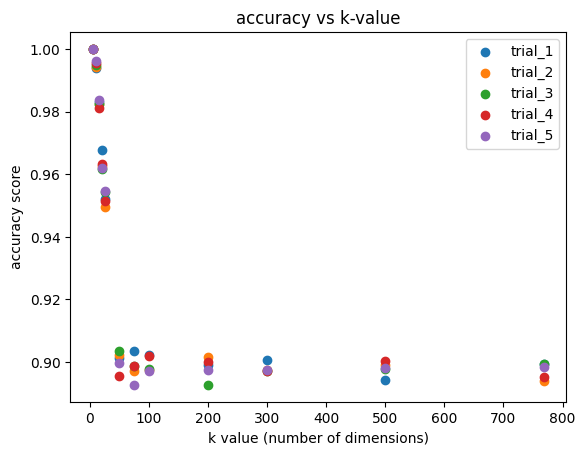

In [92]:
# plot accuracy vs k-value
for e in acc_results:
    plt.scatter(kVals, acc_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('accuracy score')
plt.title('accuracy vs k-value')
plt.show()

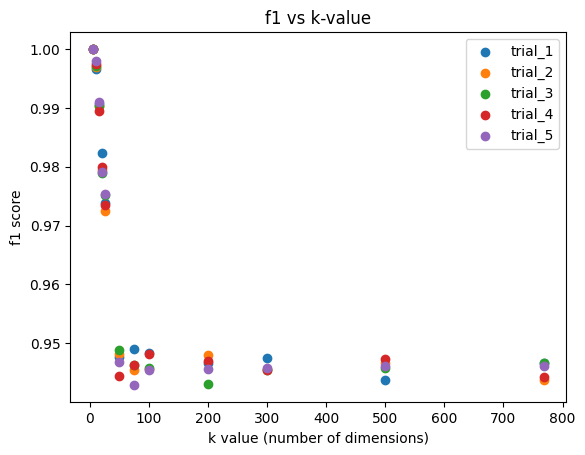

In [91]:
# plot f1 vs k_value
for e in acc_results:
    plt.scatter(kVals, f1_results[e], label=e)
plt.legend()
plt.xlabel('k value (number of dimensions)')
plt.ylabel('f1 score')
plt.title('f1 vs k-value')
plt.show()

In [ ]:
# saving kData to pickle again
# kData is the collection of all the previous trials
file = open('./pickles/training_results_transmission_1.pkl', 'wb')
kData.append(k768)
kData.append(regular)
print(kData)
pickle.dump(kData, file)
file.close()